In [224]:
import os
import csv
import torch
import argparse
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from GameFormer.predictor_new import GameFormer
from torch.utils.data import DataLoader
from GameFormer.train_utils import *

# set up model
gameformer = GameFormer(encoder_layers=3, decoder_levels=2, neighbors=10)
gameformer = gameformer.to('cuda')
gameformer.load_state_dict(torch.load('training_log/Exp_e40_dual/model_epoch_60_valADE_1.2866.pth'))


valid_path = '/data/fyy/GameFormer-Planner/nuplan/processed_data/valid/mini' + '/*.npz'
valid_files = glob.glob(valid_path)
valid_set = DrivingData(valid_files, 10)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=os.cpu_count())


epoch_loss = []
epoch_metrics = []
gameformer.eval()

for ii, batch in enumerate(valid_loader):
    # prepare data
    inputs = {
        'ego_agent_past': batch[0].to('cuda'),
        'neighbor_agents_past': batch[1].to('cuda'),
        'map_lanes': batch[2].to('cuda'),
        'map_crosswalks': batch[3].to('cuda'),
        'route_lanes': batch[4].to('cuda')
    }

    ego_future = batch[5].to('cuda')
    neighbors_future = batch[6].to('cuda')
    neighbors_future_valid = torch.ne(neighbors_future[..., :2], 0)

    # call the mdoel
    with torch.no_grad():
        level_k_outputs, ego_plan = gameformer(inputs)
        loss, results = level_k_loss(level_k_outputs, ego_future, neighbors_future, neighbors_future_valid)
        prediction = results[:, 1:]
        plan_loss = planning_loss(ego_plan, ego_future)
    if ii == 0:
        break


/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mpl_transforms
from common_utils import *
from GameFormer.data_utils import *

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
def create_map_raster(lanes, crosswalks, route_lanes):
    added_label_for_lane = False
    added_label_for_crosswalk = False
    
    for i in range(lanes.shape[0]):
        lane = lanes[i]
        if lane[0][0] != 0:
            if not added_label_for_lane:
                # plt.scatter(lane[:, 0], lane[:, 1], c='gray', marker='x', zorder=10, s=15, alpha=0.8, label='周围车道')
                plt.plot(lane[:, 0], lane[:, 1], c='#cccccc', linewidth=12, alpha = 1, zorder= 10) 
                added_label_for_lane = True
            else:
                # plt.scatter(lane[:, 0], lane[:, 1], c='gray', marker='x', zorder=10, s=15, alpha=0.8)
                plt.plot(lane[:, 0], lane[:, 1], c='#cccccc', zorder= 10, alpha = 1, linewidth=12) 
 
    for j in range(crosswalks.shape[0]):
        crosswalk = crosswalks[j]
        if crosswalk[0][0] != 0:
            if not added_label_for_crosswalk:
                plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', linewidth=4, zorder= 11, label='人行横道')  # 为人行横道添加图例标签
                added_label_for_crosswalk = True
            else:
                plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', zorder= 11, linewidth=4)


def draw_rectangles_along_path(points, width):
    length = 10
    overlap = 1  # 重叠的比例
    for i in range(0, len(points) - length, length):
        segment = points[i : i + length]
        # 计算方向向量 
        direction = segment[-1] - segment[0]
        direction_norm = np.linalg.norm(direction)
        if direction_norm == 0:
            continue
        direction_unit = direction / direction_norm
        
        # 计算垂直向量
        perpendicular = np.array([-direction_unit[1], direction_unit[0]]) * (width / 2)
        
        # 计算矩形的四个角点，稍微扩展每个矩形以避免空隙
        p1 = segment[0] - perpendicular - direction_unit * overlap
        p2 = segment[0] + perpendicular - direction_unit * overlap
        p3 = segment[-1] + perpendicular + direction_unit * overlap
        p4 = segment[-1] - perpendicular + direction_unit * overlap
        
        # 绘制矩形，包括边框
        plt.fill([p1[0], p2[0], p3[0], p4[0]], [p1[1], p2[1], p3[1], p4[1]], '#dddddd', edgecolor='#dddddd', linewidth=1)
   
      
def create_map_raster(lanes, crosswalks, route_lanes):
    added_label_for_lane = False
    added_label_for_crosswalk = False
    lane_width = 3.5  # 假设车道宽度为3.5米的一半
    lanes = lanes[:, :, :2].reshape(-1, 2)
    print(lanes.shape)
    draw_rectangles_along_path(lanes, 3)
    # draw_continuous_rectangles_along_path(lanes, 3)
    
    # for i in range(lanes.shape[0]):
    #     lane = lanes[i]
    #     if lane[0][0] != 0:
    #         for k in range(len(lane) - 1):
    #             # 计算每段中心线的方向向量
    #             segment_vector = lane[k+1] - lane[k]
    #             # 计算垂直向量
    #             perpendicular_vector = np.array([-segment_vector[1], segment_vector[0]])
    #             perpendicular_vector = perpendicular_vector / np.linalg.norm(perpendicular_vector) * lane_width

    #             # 计算矩形的四个角点
    #             # print(lane[k].shape)
    #             p1 = lane[k] + perpendicular_vector
    #             p2 = lane[k] - perpendicular_vector
    #             p3 = lane[k+1] - perpendicular_vector
    #             p4 = lane[k+1] + perpendicular_vector

    #             if not added_label_for_lane:
    #                 plt.fill([p1[0], p2[0], p3[0], p4[0]], [p1[1], p2[1], p3[1], p4[1]], 'gray', alpha=0.5, label='周围车道')
    #                 added_label_for_lane = True
    #             else:
    #                 plt.fill([p1[0], p2[0], p3[0], p4[0]], [p1[1], p2[1], p3[1], p4[1]], 'gray', alpha=0.5)

    # for j in range(crosswalks.shape[0]):
    #     crosswalk = crosswalks[j]
    #     if crosswalk[0][0] != 0:
    #         if not added_label_for_crosswalk:
    #             plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', linewidth=4, zorder=11, label='人行横道')
    #             added_label_for_crosswalk = True
    #         else:
    #             plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', zorder=11, linewidth=4)

    # plt.legend()
    
    
def create_ego_raster(vehicle_state):
    # 提取自车参数
    vehicle_parameters = get_pacifica_parameters()
    ego_width = vehicle_parameters.width
    ego_front_length = vehicle_parameters.front_length
    ego_rear_length = vehicle_parameters.rear_length

    # 提取自车状态
    x_center, y_center, heading = vehicle_state[0], vehicle_state[1], vehicle_state[2]
    ego_bottom_right = (x_center - ego_rear_length, y_center - ego_width / 2)

    # 绘制矩形以代表自车，并只为自车添加一次标签（使用label参数，但不写字）
    rect = plt.Rectangle(ego_bottom_right, ego_front_length + ego_rear_length, ego_width, linewidth=2, color='r', alpha=0.6, zorder=20, label='自车',
                         transform=mpl_transforms.Affine2D().rotate_around(x_center, y_center, heading) + plt.gca().transData)
    plt.gca().add_patch(rect)

def create_agents_raster(agents):
    # 标志变量，用于控制标签的添加
    added_label_for_agents = False    

    for i in range(agents.shape[0]):
        if agents[i, 0] != 0:
            x_center, y_center, heading = agents[i, 0], agents[i, 1], agents[i, 2]
            agent_length, agent_width = agents[i, 6], agents[i, 7]
            agent_bottom_right = (x_center - agent_length/2, y_center - agent_width/2)

            # 为第一个代理车辆添加标签，之后的代理车辆不再添加
            if not added_label_for_agents:
                rect = plt.Rectangle(agent_bottom_right, agent_length, agent_width, linewidth=2, color='m', alpha=0.6, zorder=17, label='其他交通参与者',
                                     transform=mpl_transforms.Affine2D().rotate_around(*(x_center, y_center), heading) + plt.gca().transData)
                added_label_for_agents = True
            else:
                rect = plt.Rectangle(agent_bottom_right, agent_length, agent_width, linewidth=2, color='m', alpha=0.6, zorder=17,
                                     transform=mpl_transforms.Affine2D().rotate_around(*(x_center, y_center), heading) + plt.gca().transData)
            
            plt.gca().add_patch(rect)
         
def draw_obs_trajectory(ego_trajectory, agent_trajectories, color_ego, color_others, label):
    flag = True
    # plot ego 
    plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], alpha=0.8, color=color_ego, linewidth=3, marker='.', zorder=16, label="自车"+label)
    # plot others
    for i in range(agent_trajectories.shape[0]):
        if agent_trajectories[i, -1, 0] != 0:
            trajectory = agent_trajectories[i]
            if flag:
                plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15, label="其他交通参与者"+label)
                flag = False
            plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15)
       
def draw_fut_trajectory(ego_trajectory, agent_trajectories, color_ego, color_others):
    # plot ego 
    plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], alpha=0.8, color=color_ego, linewidth=3, marker='.', zorder=16)

    # plot others
    for i in range(agent_trajectories.shape[0]):
        if agent_trajectories[i, -1, 0] != 0:
            trajectory = agent_trajectories[i]
            plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15)
            
def draw_pred_trajectory(ego_trajectory, agent_trajectories, color_ego, color_others, label):
    flag = True
    # plot ego 
    # plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], alpha=0.8, color=color_ego, linewidth=3, marker='.', zorder=16, label="自车"+label)
    # plt.plot(ego_trajectory[-1, 0], ego_trajectory[-1, 1], marker='o', color=color_ego, markersize=12, alpha=0.75, zorder=30, label=label)

    # plot others
    for i in range(agent_trajectories.shape[0]):
        if agent_trajectories[i, -1, 0] != 0:
            trajectory = agent_trajectories[i]
            if flag:
                plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15, label="其他交通参与者"+label)
                flag = False
            plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15)
      

In [227]:
idx = 19
m = 80

torch.Size([2000, 2])


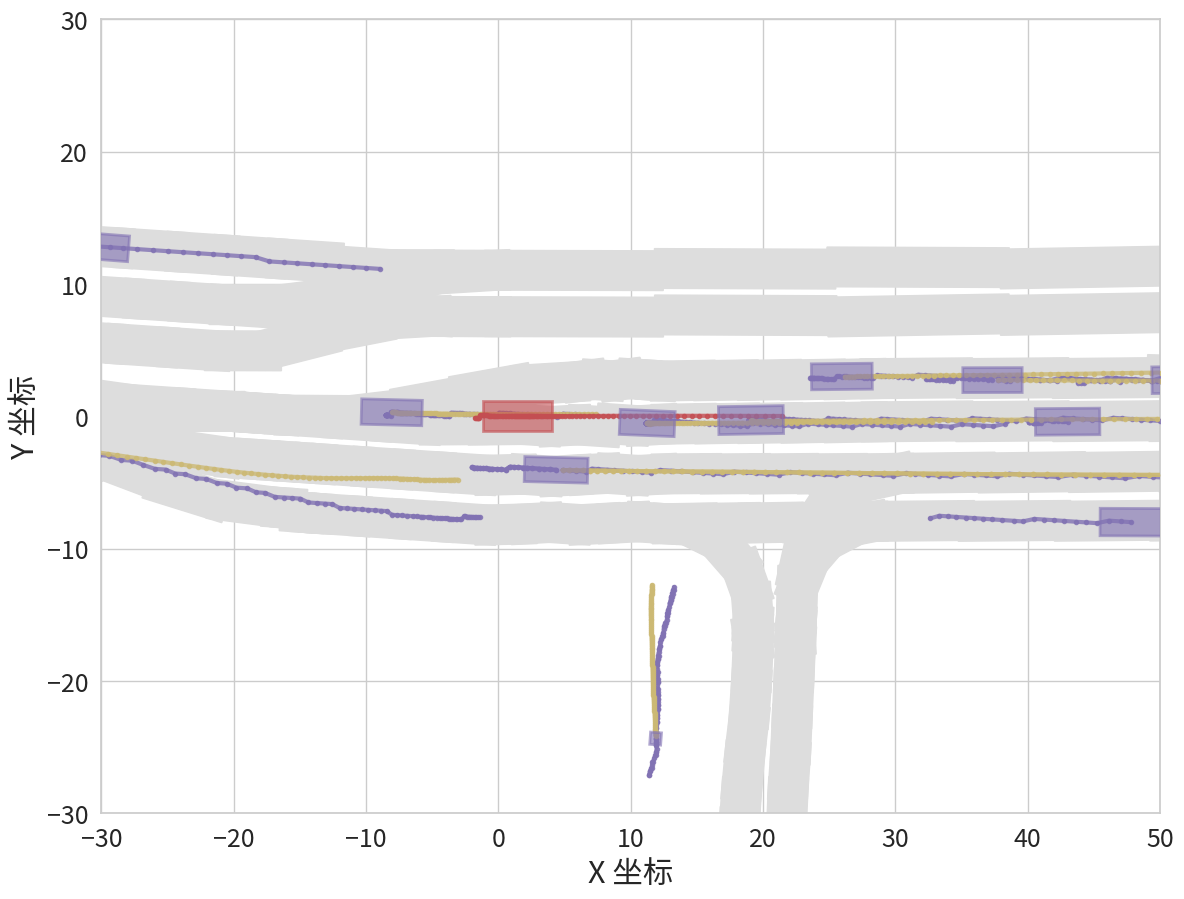

In [228]:
# plt.figure(figsize=(8, 8))
plt.figure(figsize=(12, 12))
plt.xlim(-30, 50) 
plt.ylim(-30, 30) 
# plt.gca().set_facecolor('black')

ego_agent_past = batch[0][idx]
neighbor_agents_past = batch[1][idx]
lanes = batch[2][idx]
crosswalks = batch[3][idx]
route_lanes = batch[4][idx]

ego_future = batch[5][idx]
neighbors_future = batch[6][idx]
# neighbors_future_valid = torch.ne(neighbors_future[..., :2], 0)[idx]

ego_agent_future = results[idx, 0].cpu()
neighbor_agents_future = results[idx, 1:].cpu()

create_map_raster(lanes, crosswalks, route_lanes)
create_agents_raster(neighbor_agents_past[:, -1])
create_ego_raster(ego_agent_past[-1])

# Draw past and future trajectories
if (ii == 2 and idx == 29) or (ii == 3 and idx == 0):
    m = 60
draw_obs_trajectory(ego_agent_past, neighbor_agents_past, 'r', 'm', '行驶轨迹')
draw_fut_trajectory(ego_future[:m], neighbors_future[:m], 'r', 'm')
draw_pred_trajectory(ego_agent_future[:m], neighbor_agents_future[:m], 'g', 'y', '预测轨迹')



plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X 坐标', fontsize=22)
plt.ylabel('Y 坐标', fontsize=22)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=14, ncol=3)

# plt.legend(fontsize=18)
# plt.grid(False)
# plt.axis('off')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.axis('equal')
# 隐藏坐标轴的数字
# ax = plt.gca()
# ax.set_xticklabels([])
# ax.set_yticklabels([])
plt.savefig(f'fig/pred/pred_{ii}_{idx}.pdf')
# plt.savefig("fig/pred/pred_label.pdf")

In [210]:
aaa

NameError: name 'aaa' is not defined

torch.Size([2000, 2])
torch.Size([2000, 2])
torch.Size([2000, 2])
torch.Size([2000, 2])
torch.Size([2000, 2])


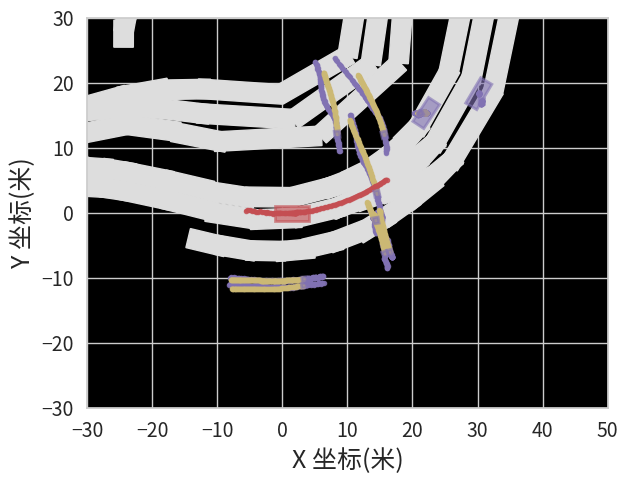

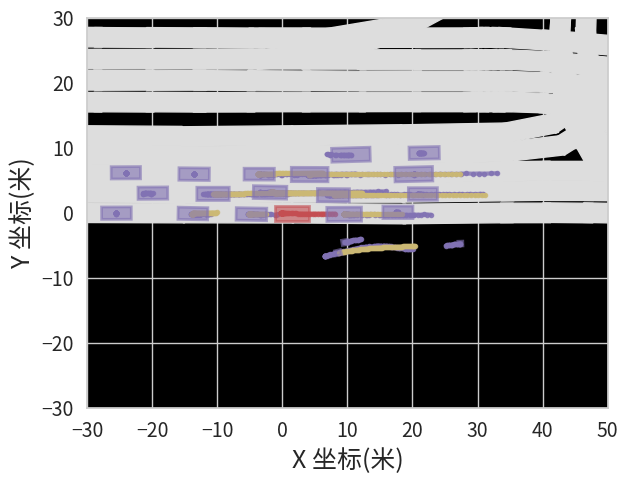

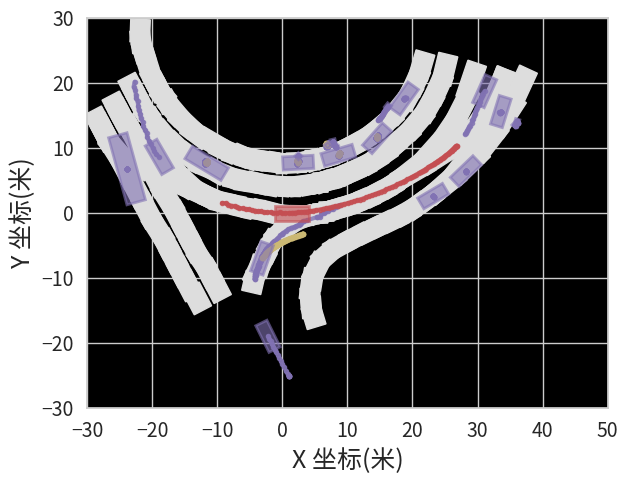

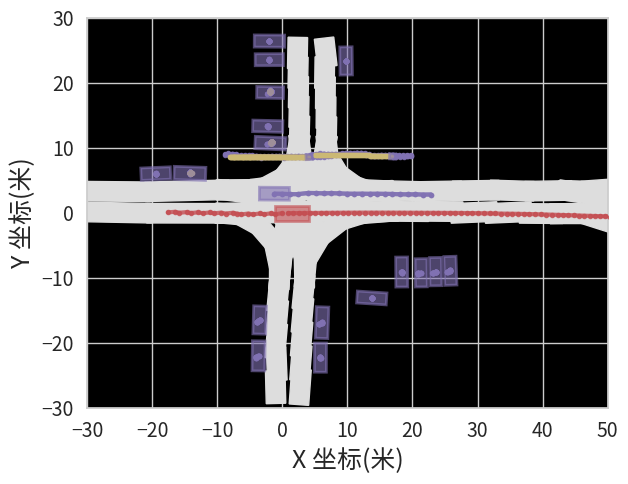

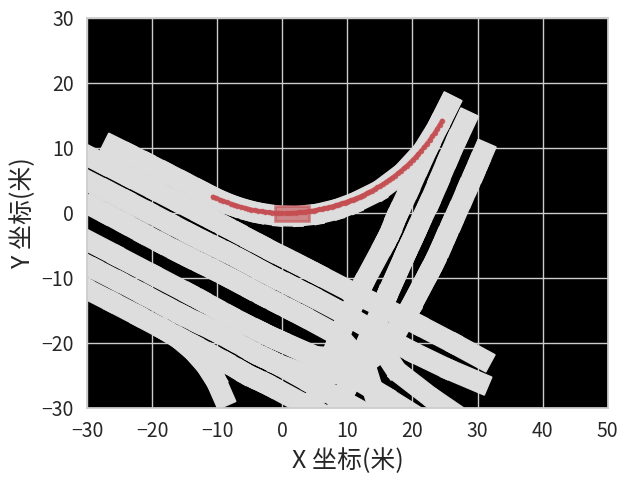

In [ ]:
if ii == 0:
    idx_list = [0, 1, 4, 10, 11, 12, 17, 18, 19, 20, 26]
if ii == 1:
    idx_list = [0, 3, 11, 16, 18]
if ii == 2:
    idx_list = [10, 18, 26, 28, 29]
if ii == 3:
    idx_list = [0, 4, 21, 23, 24]

for idx in idx_list:
    plt.figure(figsize=(10, 5))
    plt.xlim(-30, 50) 
    plt.ylim(-30, 30) 
    plt.gca().set_facecolor('black')

    ego_agent_past = batch[0][idx]
    neighbor_agents_past = batch[1][idx]
    lanes = batch[2][idx]
    crosswalks = batch[3][idx]
    route_lanes = batch[4][idx]

    ego_future = batch[5][idx]
    neighbors_future = batch[6][idx]
    # neighbors_future_valid = torch.ne(neighbors_future[..., :2], 0)[idx]

    ego_agent_future = results[idx, 0].cpu()
    neighbor_agents_future = results[idx, 1:].cpu()

    create_map_raster(lanes, crosswalks, route_lanes)
    create_agents_raster(neighbor_agents_past[:, -1])
    create_ego_raster(ego_agent_past[-1])

    # Draw past and future trajectories
    if (ii == 2 and idx == 29) or (ii == 3 and idx == 0):
        m = 60
    draw_obs_trajectory(ego_agent_past, neighbor_agents_past, 'r', 'm', '行驶轨迹')
    draw_fut_trajectory(ego_future[:m], neighbors_future[:m], 'r', 'm')
    draw_pred_trajectory(ego_agent_future[:m], neighbor_agents_future[:m], 'g', 'y', '预测轨迹')



    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X 坐标(米)', fontsize=18)
    plt.ylabel('Y 坐标(米)', fontsize=18)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
    # plt.legend(fontsize=18)
    # plt.grid(False)
    # plt.axis('off')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    # plt.axis('equal')
    # 隐藏坐标轴的数字
    # ax = plt.gca()
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    plt.savefig(f'fig/pred_{ii}_{idx}.pdf')